In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import copy
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [ ]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 44.11 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [ ]:
from continualai.colab.scripts import mnist

mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
class my_model(
    nn.Module
    ): 

    def __init__(
        self
        ):

        super(my_model, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.drop_1 = nn.Dropout2d()
        self.fc_1 = nn.Linear(320, 50)
        self.drop_2 = nn.Dropout1d()
        self.fc_2 = nn.Linear(50, 10)

    def forward(
        self, 
        x
        ):
      
        x = F.relu(F.max_pool2d(self.conv_1(x), 2))
        x = F.relu(F.max_pool2d(self.drop_1(self.conv_2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(self.drop_2(x))
        
        return x
    
    def add_neurons(
        self,
        new_neurons,
        device
        ):
        
      with torch.no_grad():
        
        fc_1_w_prev = self.fc_1.weight
        fc_1_b_prev = self.fc_1.bias

        fc_2_w_prev = self.fc_2.weight
        fc_2_b_prev = self.fc_2.bias

        self.fc_1 = nn.Linear(fc_1_w_prev.shape[1], fc_1_w_prev.shape[0] + new_neurons)
        self.fc_1.weight[:fc_1_w_prev.shape[0], :].copy_(fc_1_w_prev)
        self.fc_1.bias[:fc_1_w_prev.shape[0]].copy_(fc_1_b_prev)

        self.fc_2 = nn.Linear(fc_2_w_prev.shape[1] + new_neurons, fc_2_w_prev.shape[0])
        self.fc_2.weight[:, :fc_2_w_prev.shape[1]].copy_(fc_2_w_prev)
        self.fc_2.bias[:fc_2_w_prev.shape[0]].copy_(fc_2_b_prev)

      self.to(device)

In [ ]:
class my_agent():

  def __init__(
      self,
      ewc_flag=False,
      permutations=5,
      epochs_per_permutation=5,
      batch_size=256,
      learning_rate=0.01,
      momentum=0.9,
      ewc_lambda=0.2,
      new_neurons_per_task=0,
      colors=None
      ):
    
    self.X_train, self.Y_train, self.X_test, self.Y_test = mnist.load()
    self.X_train, self.X_test = [self.X_train], [self.X_test]

    self.permutations, self.epochs_per_permutation = permutations, epochs_per_permutation
    seeds = random.sample(range(0, 1000), self.permutations - 1)

    for seed in seeds:

      np.random.seed(seed)
      permute_idx = list(range(784))
      np.random.shuffle(permute_idx)

      self.X_train.append(self.X_train[0].reshape(self.X_train[0].shape[0], 784)[:, permute_idx].reshape(self.X_train[0].shape[0], 1, 28, 28))
      self.X_test.append(self.X_test[0].reshape(self.X_test[0].shape[0], 784)[:, permute_idx].reshape(self.X_test[0].shape[0], 1, 28, 28))

    self.batch_size = batch_size
    self.model = my_model()

    if torch.cuda.is_available():

      torch.cuda.manual_seed(1)
      self.device = torch.device('cuda')
      torch.cuda.set_device(0)

    else:

      self.device = torch.device('cpu')
      torch.manual_seed(1)

    self.model.to(self.device)
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)
    self.ewc_flag, self.ewc_lambda, self.fisher, self.optpar = ewc_flag, ewc_lambda, {}, {}
    self.new_neurons_per_task = new_neurons_per_task

    if colors == None:

      self.colors = []

      for perm in range(self.permutations):

        self.colors.append([random.randint(0, 255) / 255, random.randint(0, 255) / 255, random.randint(0, 255) / 255])

    else:

      self.colors = colors

  def update_task(
      self,
      task_id,
      X,
      Y
      ):
    
    self.model.train()
    self.optimizer.zero_grad()

    for start in range(0, len(Y) - 1, self.batch_size):

      end = start + self.batch_size

      x, y = torch.from_numpy(X[start:end]), torch.from_numpy(Y[start:end]).long()
      x, y = x.to(self.device), y.to(self.device)

      outputs = self.model(x)

      loss = F.cross_entropy(outputs, y)
      loss.backward()

    self.fisher[task_id], self.optpar[task_id] = {}, {}

    for name, param in self.model.named_parameters():
    
      self.optpar[task_id][name] = param.data.clone()
      self.fisher[task_id][name] = param.grad.data.clone().pow(2)

    for task_id_ in range(task_id):

      for name, param in self.model.named_parameters():

        if self.optpar[task_id_][name].shape >= self.optpar[task_id][name].shape:

          if len(self.optpar[task_id][name].shape) == 2:

            aux_optpar = self.optpar[task_id_][name][:self.optpar[task_id][name].shape[0], :self.optpar[task_id][name].shape[1]]
            aux_fisher = self.fisher[task_id_][name][:self.fisher[task_id][name].shape[0], :self.fisher[task_id][name].shape[1]]

          else:

            aux_optpar = self.optpar[task_id_][name][:self.optpar[task_id][name].shape[0]]
            aux_fisher = self.fisher[task_id_][name][:self.fisher[task_id][name].shape[0]]

        else:

          if len(self.optpar[task_id][name].shape) == 2:

            aux_optpar = torch.zeros(self.optpar[task_id][name].shape, dtype=self.optpar[task_id][name].dtype, device=self.device)
            aux_optpar[:self.optpar[task_id_][name].shape[0], :self.optpar[task_id_][name].shape[1]] = self.optpar[task_id_][name]
            aux_fisher = torch.zeros(self.fisher[task_id][name].shape, dtype=self.fisher[task_id][name].dtype, device=self.device)
            aux_fisher[:self.fisher[task_id_][name].shape[0], :self.fisher[task_id_][name].shape[1]] = self.fisher[task_id_][name]

          else:

            aux_optpar = torch.zeros(self.optpar[task_id][name].shape, dtype=self.optpar[task_id][name].dtype, device=self.device)
            aux_optpar[:self.optpar[task_id_][name].shape[0]] = self.optpar[task_id_][name]
            aux_fisher = torch.zeros(self.fisher[task_id][name].shape, dtype=self.fisher[task_id][name].dtype, device=self.device)
            aux_fisher[:self.fisher[task_id_][name].shape[0]] = self.fisher[task_id_][name]

        self.optpar[task_id_][name] = aux_optpar
        self.fisher[task_id_][name] = aux_fisher

    self.optimizer.zero_grad()

  def run(
      self
      ):
    
    self.train_losses = []
    self.test_losses = [[] for perm in range(self.permutations)]
    self.test_correct = [[] for perm in range(self.permutations)]
    self.task_window = [[] for perm in range(self.permutations)]

    for perm in range(self.permutations):

      for epoch in range(self.epochs_per_permutation):

        train_loss = self.train_epoch(self.X_train[perm], self.Y_train, perm)
        self.train_losses.append(train_loss)

        plt.figure(figsize=(14,7))

        for perm_ in range(self.permutations):
          
          test_loss, test_correct = self.test_epoch(self.X_test[perm_], self.Y_test)
          self.test_losses[perm_].append(test_loss)
          self.test_correct[perm_].append(test_correct)
          
          if perm_ == perm:

            self.task_window[perm_].append(50)

          else:

            self.task_window[perm_].append(0)

          plt.plot(self.test_correct[perm_], linewidth=3, color=self.colors[perm_], label=f"Permutation {perm_ + 1} Accuracy")
          plt.plot(self.task_window[perm_], linewidth=1, linestyle="--", color=self.colors[perm_], label=f"Permutation {perm_ + 1} Training Window")
   
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.ylim([0, 100])
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy [%]")
        plt.title("Running Accuracy Plot")
        plt.show()

        clear_output(wait=True)

      self.model.add_neurons(self.new_neurons_per_task, self.device)
      self.update_task(perm, self.X_train[perm], self.Y_train)

  def train_epoch(
      self,
      X,
      Y,
      task_id
      ):
    
    self.model.train()

    train_loss = 0.0

    for start in range(0, len(Y) - 1, self.batch_size):

      end = start + self.batch_size

      x, y = torch.from_numpy(X[start:end]), torch.from_numpy(Y[start:end]).long()
      x, y = x.to(self.device), y.to(self.device)

      outputs = self.model(x)

      loss = F.cross_entropy(outputs, y)

      if self.ewc_flag:

        for task_id_ in range(task_id):

          for name, param in self.model.named_parameters():
            
            fisher = self.fisher[task_id_][name]
            optpar = self.optpar[task_id_][name]

            loss += (fisher * (optpar - param).pow(2)).sum() * self.ewc_lambda

      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      train_loss += loss.item()

    return train_loss / len(Y)

  def test_epoch(
      self,
      X,
      Y
      ):
    
    self.model.eval()

    test_loss = 0.0
    correct = 0

    with torch.no_grad():

      for start in range(0, len(Y) - 1, self.batch_size):

        end = start + self.batch_size

        x, y = torch.from_numpy(X[start:end]), torch.from_numpy(Y[start:end]).long()
        x, y = x.to(self.device), y.to(self.device)

        outputs = self.model(x)

        loss = F.cross_entropy(outputs, y)
        test_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(y.view_as(predicted)).sum().item()

      return test_loss / len(Y), correct / len(Y) * 100

In [ ]:
permutations = 3
epochs_per_permutation = 10

colors = []

for perm in range(permutations):
  
  colors.append([random.randint(0, 255) / 255, random.randint(0, 255) / 255, random.randint(0, 255) / 255])

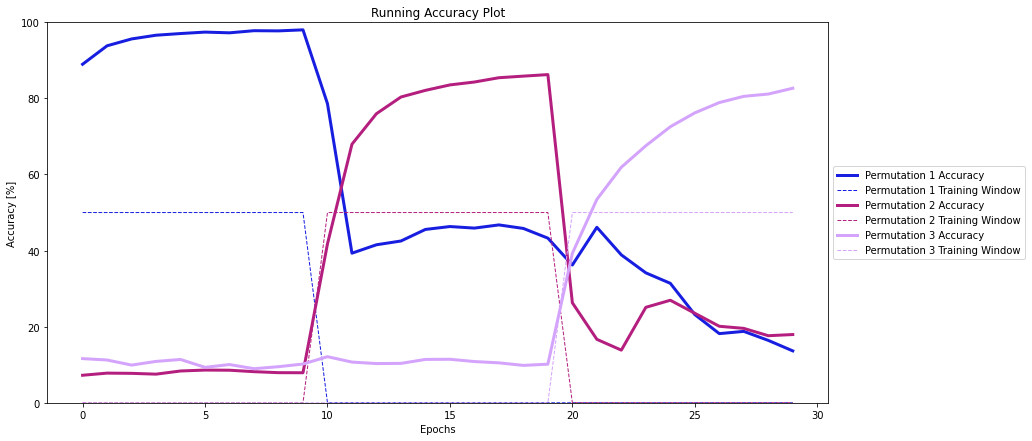

In [ ]:
# Normal Neural Network

agent = my_agent(ewc_flag=False, permutations=permutations, epochs_per_permutation=epochs_per_permutation, new_neurons_per_task=0, colors=colors)
agent.run()

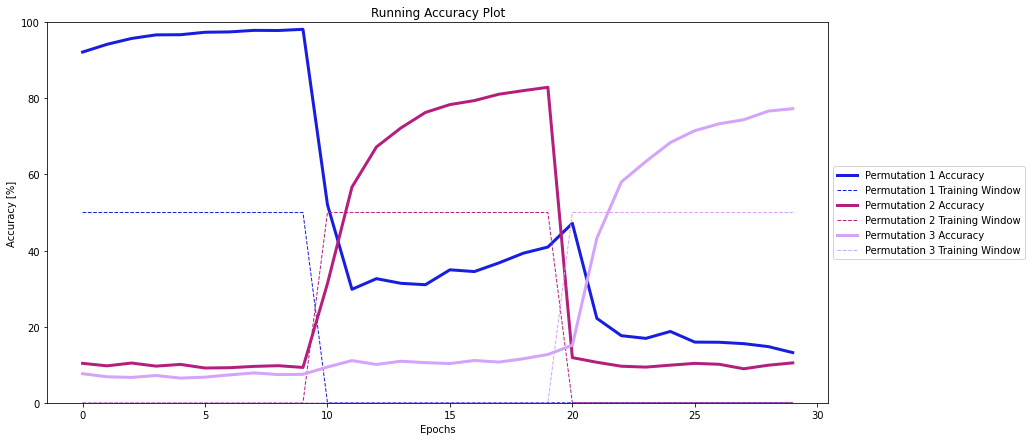

In [ ]:
# Expanding Neural Network

agent_expand = my_agent(ewc_flag=False, permutations=permutations, epochs_per_permutation=epochs_per_permutation, new_neurons_per_task=15, colors=colors)
agent_expand.run()

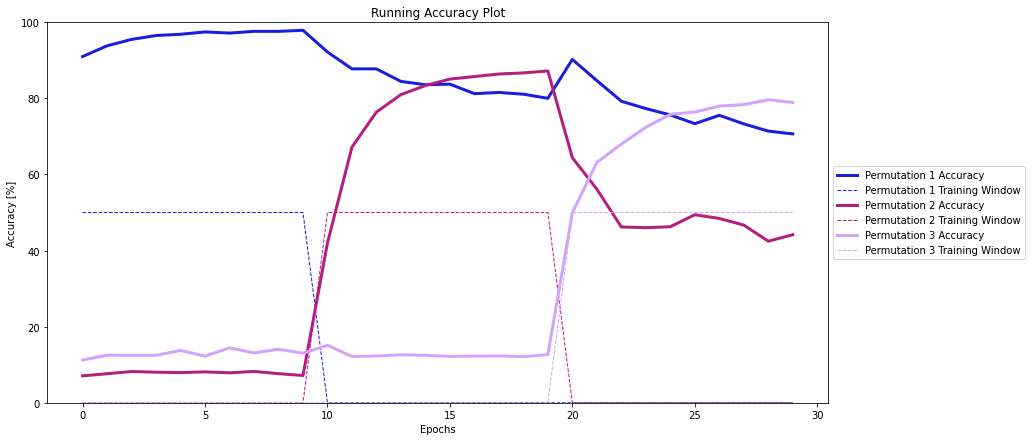

In [ ]:
# Expanding Neural Network with Elastic Weight Consolidation

agent_expand_ewc = my_agent(ewc_flag=True, permutations=permutations, epochs_per_permutation=epochs_per_permutation, new_neurons_per_task=15, colors=colors)
agent_expand_ewc.run()